In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar  9 02:39 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


In [3]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test/cats/cat.1524.jpg  
  inf

In [4]:
!ls -l

total 20
drwx------ 5 root root 4096 Apr 11 06:56 drive
drwxr-xr-x 1 root root 4096 Apr  7 13:36 sample_data
drwxr-xr-x 4 root root 4096 Apr 11 06:56 test
drwxr-xr-x 4 root root 4096 Apr 11 06:56 train
drwxr-xr-x 4 root root 4096 Apr 11 06:56 validation


In [5]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

# VGG16 모델 call & trainable =False

In [6]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))


conv_base.trainable = False
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

# with Function

In [16]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  X = np.zeros(shape=(sample_count, 4,4,512))
  y = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size, class_mode='binary')
  
  i = 0
  for x_batch, y_batch in generator:
    X_predict = conv_base.predict(x_batch)
    X[i*batch_size:(1+i)*batch_size] =X_predict
    y[i*batch_size:(1+i)*batch_size] = y_batch

    i += 1
    if (i+1)*batch_size >= sample_count:
      break
  return X, y

In [17]:
%%time
train_X, train_y = extract_features(train_dir, 2000)
valid_X, valid_y = extract_features(valid_dir, 1000)
test_X, test_y = extract_features(test_dir, 1000)

print(train_X.shape, valid_X.shape, test_X.shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(2000, 4, 4, 512) (1000, 4, 4, 512) (1000, 4, 4, 512)
CPU times: user 21 s, sys: 4.35 s, total: 25.4 s
Wall time: 25.2 s


In [18]:
train_X = train_X.reshape(2000, 4*4*512)
valid_X = np.reshape(valid_X, (1000, 4*4*512))
test_X = np.reshape(test_X, (1000, 4*4*512))

train_X.shape, valid_X.shape, test_X.shape

((2000, 8192), (1000, 8192), (1000, 8192))

In [20]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [21]:
%%time
Hist = model.fit(train_X, train_y, epochs=100, batch_size=20, validation_data=(valid_X, valid_y))


Epoch 1/100
100/100 [==============================] - 1s 6ms/step - loss: 0.5844 - accuracy: 0.7447 - val_loss: 0.2853 - val_accuracy: 0.8900
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2626 - accuracy: 0.9016 - val_loss: 0.2610 - val_accuracy: 0.9020
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2020 - accuracy: 0.9218 - val_loss: 0.2692 - val_accuracy: 0.8940
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1674 - accuracy: 0.9388 - val_loss: 0.2630 - val_accuracy: 0.9030
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9449 - val_loss: 0.2685 - val_accuracy: 0.9030
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1349 - accuracy: 0.9438 - val_loss: 0.2737 - val_accuracy: 0.9000
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1001 - accuracy: 0.9639 - val_loss: 0.2855 - val_accuracy: 0.8960

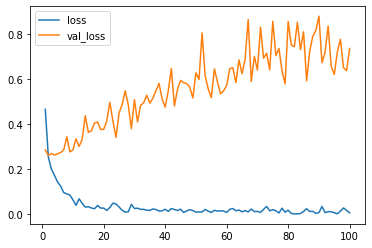

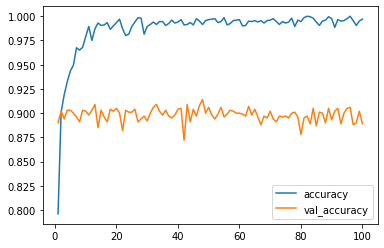

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss'])+1)

plt.plot(epochs, Hist.history['loss'])
plt.plot(epochs, Hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

plt.plot(epochs, Hist.history['accuracy'])
plt.plot(epochs, Hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [24]:
loss, accuracy = model.evaluate(test_X, test_y)
loss, accuracy

32/32 [==============================] - 0s 3ms/step - loss: 0.7453 - accuracy: 0.8870


(0.7453212141990662, 0.8870000243186951)

# with model concat

In [25]:
from keras import models, layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(150,150), batch_size=20, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
%%time
Hist = model.fit(train_generator, steps_per_epoch=100, epochs=100, validation_data=valid_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 11s 106ms/step - loss: 0.6376 - accuracy: 0.7469 - val_loss: 0.3853 - val_accuracy: 0.8040
Epoch 2/100
100/100 [==============================] - 10s 104ms/step - loss: 0.2890 - accuracy: 0.8665 - val_loss: 0.3409 - val_accuracy: 0.8510
Epoch 3/100
100/100 [==============================] - 10s 104ms/step - loss: 0.2221 - accuracy: 0.9055 - val_loss: 0.2593 - val_accuracy: 0.8930
Epoch 4/100
100/100 [==============================] - 11s 105ms/step - loss: 0.1563 - accuracy: 0.9444 - val_loss: 0.2431 - val_accuracy: 0.9030
Epoch 5/100
100/100 [==============================] - 10s 104ms/step - loss: 0.1418 - accuracy: 0.9519 - val_loss: 0.2762 - val_accuracy: 0.8890
Epoch 6/100
100/100 [==============================] - 10s 104ms/step - loss: 0.1608 - accuracy: 0.9382 - val_loss: 0.2475 - val_accuracy: 0.8980
Epoch 7/100
100/100 [==============================] - 10s 104ms/step - loss: 0.0856 - accuracy: 0.9696 - val_loss: 0.2727 -

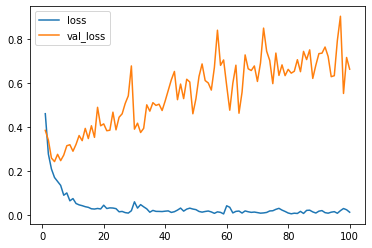

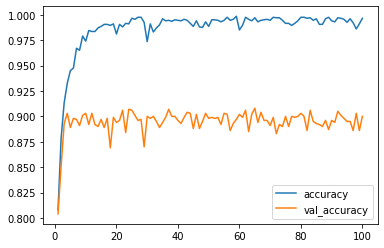

In [29]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss'])+1)

plt.plot(epochs, Hist.history['loss'])
plt.plot(epochs, Hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

plt.plot(epochs, Hist.history['accuracy'])
plt.plot(epochs, Hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [31]:
loss, accuracy = model.evaluate(test_generator, steps=50)
loss, accuracy

50/50 [==============================] - 3s 68ms/step - loss: 0.7374 - accuracy: 0.8790


(0.7374285459518433, 0.8790000081062317)

# generator 1개만 생성_share

In [32]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)


train_generator = datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
valid_generator = datagen.flow_from_directory(valid_dir, target_size=(150,150), batch_size=20, class_mode='binary')
test_generator = datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
%%time
Hist = model.fit(train_generator, steps_per_epoch=100, epochs=20, validation_data=valid_generator, validation_steps=50)

Epoch 1/20
100/100 [==============================] - 10s 101ms/step - loss: 0.0198 - accuracy: 0.9935 - val_loss: 0.7011 - val_accuracy: 0.8970
Epoch 2/20
100/100 [==============================] - 10s 101ms/step - loss: 0.0051 - accuracy: 0.9975 - val_loss: 0.6822 - val_accuracy: 0.9000
Epoch 3/20
100/100 [==============================] - 10s 101ms/step - loss: 0.0101 - accuracy: 0.9955 - val_loss: 0.6700 - val_accuracy: 0.9040
Epoch 4/20
100/100 [==============================] - 10s 102ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.7887 - val_accuracy: 0.9010
Epoch 5/20
100/100 [==============================] - 10s 102ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.8152 - val_accuracy: 0.9070
Epoch 6/20
100/100 [==============================] - 10s 101ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.8325 - val_accuracy: 0.8920
Epoch 7/20
100/100 [==============================] - 10s 101ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.8220 - val_ac

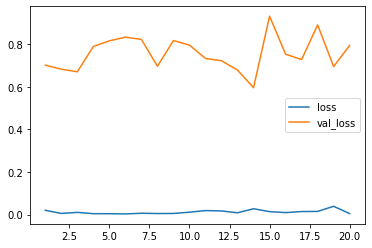

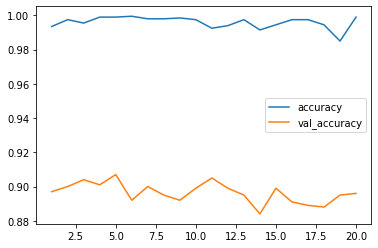

In [34]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss'])+1)

plt.plot(epochs, Hist.history['loss'])
plt.plot(epochs, Hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

plt.plot(epochs, Hist.history['accuracy'])
plt.plot(epochs, Hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_generator, steps=50)
loss, accuracy

50/50 [==============================] - 3s 68ms/step - loss: 0.8316 - accuracy: 0.8820


(0.831619918346405, 0.8820000290870667)

# extraction 연습

In [47]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  X = np.zeros(shape=(sample_count, 4,4,512))
  y = np.zeros(shape=(sample_count))

  generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size, class_mode='binary')
  print(directory,'len(generator):',len(generator)) # (train_dir)값 = 100, 따라서 batch_size 20개씩 100개
  i = 0
  for x_batch, y_batch in generator:
    X_predict = conv_base.predict(x_batch)
    X[i*batch_size: (1+i)*batch_size] = X_predict
    y[i*batch_size:(1+i)*batch_size] = y_batch

    i += 1
    if i*batch_size >= sample_count:
      print('i:',i)
      break
  return X, y

In [49]:
%%time

train_X, train_y = extract_features(train_dir, 2000)
valid_X, valid_y = extract_features(valid_dir, 1000)
test_X, test_y = extract_features(test_dir, 1000)

print(train_X.shape, valid_X.shape, test_X.shape)

Found 2000 images belonging to 2 classes.
train len(generator): 100
i: 100
Found 1000 images belonging to 2 classes.
validation len(generator): 50
i: 50
Found 1000 images belonging to 2 classes.
test len(generator): 50
i: 50
(2000, 4, 4, 512) (1000, 4, 4, 512) (1000, 4, 4, 512)
CPU times: user 21.3 s, sys: 4.34 s, total: 25.7 s
Wall time: 25.4 s
